# CIFAR-10 Classification

本章節將會用 [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) 的資料集進行影像分類的訓練，在 torchvision 中 CIFAR-10 為內建的資料，我們不須再自訂義 dataset



## Dataset

In [38]:
import torchvision
from torchvision import transforms

train_transform = transforms.Compose([
    # TO DO: modify the transformation and see what happen!                                  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='cifar_data', train=True, download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='cifar_data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


# DataLoader

In [39]:
import torch

trainloader = torch.utils.data.DataLoader(trainset, batch_size=500, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)

# Show Image

<Figure size 2880x2880 with 0 Axes>

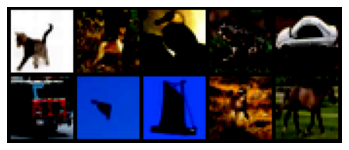

<Figure size 2880x2880 with 0 Axes>

In [40]:
from collections import Counter
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

classes_pair = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

data_label = np.array(trainset.targets)
data = []

chosen_counter = Counter()
for _ in range(len(classes_pair)):
    # sample until we have a pair of class with insufficient client owning
    class_pair = random.choice(classes_pair)
    while chosen_counter[class_pair] == 1:
        class_pair = random.choice(classes_pair)
        
    chosen_counter[class_pair] += 1
        
    first_class_sample_idx = list(np.where(data_label == class_pair)[0])
    
    client_first_class_sample_idx = random.sample(first_class_sample_idx, k=1)
    
    for i in range(1):
        data.append(trainset[client_first_class_sample_idx[i]][0])
    
    grid = torchvision.utils.make_grid(data, nrow=5)

plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.figure(figsize=(40, 40))

## Model Architecture

In [41]:
import torch.nn as nn

# TO DO: modify the model architecture to get better result
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = x.view(x.size(0), -1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

def create_model():
  model = torchvision.models.densenet121(pretrained=True)
  model.classifier = nn.Sequential(
      nn.Linear(model.classifier.in_features, 256),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(256, 10)
  )
  return model

if __name__ == '__main__':
  x = torch.randn(1, 3, 32, 32)
  net = Net()
  print(net(x).shape)

torch.Size([1, 10])


## Criterion

In [42]:
def criterion():
  return nn.CrossEntropyLoss()

# Trainer

In [43]:
def trainer(model, data_loader, device, criterion, optimizer):

  total_loss = 0
  total_acc = 0

  model.train()
  for images, labels in data_loader:

    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

    total_acc += (preds == labels).sum() / data_loader.__len__() / images.size(0)

    # TO DO: add your learninig rate scheduler here

    optimizer.zero_grad()
    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()

    total_loss += loss.item() / data_loader.__len__()

  return total_loss, total_acc

def evaluate(model, data_loader, device):

  total_acc = 0

  model.eval()
  with torch.no_grad():
    for images, labels in data_loader:

      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      preds = torch.argmax(outputs, dim=1)

      total_acc += (preds == labels).sum() / data_loader.__len__() / images.size(0)

  return total_acc

In [44]:
BATCH_SIZE = 200
LR = 0.01
WEIGHT_DECAY = 0
RESUME = False
START_EPOCH = 0
EPOCHS = 50

In [45]:
import time
import datetime

def main():

    global START_EPOCH

    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    batch_size = BATCH_SIZE

    #model = Net()
    model = create_model()
    model.to(device)

    params_to_optimize = [
        {"params": [p for p in model.parameters() if p.requires_grad]},
    ]

    optimizer = torch.optim.SGD(
        params_to_optimize,
        lr=LR, weight_decay=WEIGHT_DECAY
    )

    if RESUME:
        checkpoint = torch.load(RESUME, map_location='cpu')
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        START_EPOCH = checkpoint['epoch'] + 1

    start_time = time.time()
    for epoch in range(START_EPOCH, EPOCHS):

        loss_func = criterion()

        mean_loss, train_acc = trainer(model, trainloader, device, loss_func ,optimizer)
        
        test_acc = evaluate(model, testloader, device)

        save_file = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            }
        torch.save(save_file, f"model.pth")

        print(f"Epoch [{epoch}] train Accuracy: {train_acc:.2f} test Accuracy: {test_acc:.2f}")

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print("training time {}".format(total_time_str))

if __name__ == '__main__':
  main()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [0] train Accuracy: 0.27 test Accuracy: 0.47
Epoch [1] train Accuracy: 0.53 test Accuracy: 0.62


TypeError: ignored